TODO:
- Better explanation of priors
- Add more explanatory text
- Make sure the conclusion of hypothesis is clear 
- Better explain posterior results
- Add clarity of trace plots.
- Decide which data visualizations we would like to include? Boxplot, mean ...

# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam by Raúl Pardo ([raup@itu.dk](mailto:raup@itu.dk)) and Andrzej Wąsowski ([wasowski@itu.dk](mailto:wasowski@itu.dk))*<br/>
*version 1.0.0 2025-03-20 08:40*


In this exam, your task is to analyze energy consumption of different implementations of a web application.
The goal is to determine whether there are differences in energy consumption in different implementations of the web application or in its API endpoints.
This analysis is of utmost importance, as it might help software engineers to make informed choices that lower energy consumption. For instance, a plausible hypothesis is that lower level programming languages such as Rust consume less energy than higher level languages such as Python.
A preconception in this domain is that running time is the driving factor in energy consumption.
Are these true? The data in this exam and the analysis you will develop will allow to answer this type of questions.

## Data

The dataset contains $N = 1960$ measurements of energy consumption for different implementations and functionality of a web application. For each setup, there are 20 measurements. The dataset is in the file [dataset.csv](dataset.csv). The variables in the dataset are:

* **Application**. This variable has the form `<programming_language>-<web_framework>`. It specifies the programming language and web framework used in the experiment. For instance, `rust-actix` denotes the web framework Actix for the programming language Rust, or `c-sharp-razor` denotes the web framework Razor for the programming language C#.
    * Note that if a hypothesis involves only programming language, you need to extract it from the values in this variable.

* **Endpoint**. This variable refers to the API endpoints of the web application. For example, `/api/register` refers to the API endpoint used for registering users in the web application, or `/logout` is used for logging out of the system.

* **Runtime**. This variable indicates the time it took to process the request to the endpoint in seconds.

* **Energy consumption**. This variable indicates the energy consumed for processing the request to the endpoint in Joules.

Each row in the dataset is a measurement of the total energy consumed and runtime after processing a request in the corresponding API endpoint. The *Application* variable in each row indicates the web framework used for the measurement.

## Hypotheses

To analyze energy consumption in the different implementations, you must investigate the following hypotheses:

* **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

* **H2** - The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.

* **H3** - Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

Your task is to use Bayesian Inference and Regression to decide whether these hypotheses hold, or possibly reject them. This includes:

* Loading, restructuring and transforming the data as needed.

* Designing Bayesian regression models and using inference algorithms to test the above hypotheses in PyMC.

* Explaining your model idea in English, preferably using a figure, and showing the Python code.

* Checking and reflecting (in writing) on the quality of the sampling process, considering warnings from the tool, sampling summary statistics, trace plots, and autocorrelation plots. Comment whether the quality of the sampled trace is good, and whether you had to make any adjustments during modeling and/or sampling.

* Visualizing the posterior information appropriately to address the hypotheses.
  

You should hand in a zip file with a Jupyter notebook and the data file (so that we can run it), and a **PDF file rendering of the Jupyter notebook**, so that your work can be assessed just by reading this file. It appears that the best PDF rendering is obtained by File / Export to HTML, and then saving/printing to PDF from your browser.

Make sure the notebook is actually a **report** readable to the examiners, especially to the censor who has not followed the course. The report should include:
* A brief introduction.
* Explanations on how data is loaded and cleaned.
* Explanations on analysis and model design (for each of the models you consider).
* A discussion of sampling quality (for each model) and all the plots that you present, and a reflection/decision on the outcome for each hypothesis.
* An overall conclusion.

**IMPORTANT:** For the tasks below, your code must accompany an explanation of its meaning and intended purpose. **Source code alone is not self-explanatory**. As mentioned above, you should also reflect on the results you get, e.g., highlighting issues with the data, or issues, pitfalls and assumptions of a model. **Exams containing only source code or very scarce explanations will result in low grades, including failing grades.**





## Minimum requirements 

1. Design a regression model to predict energy consumption using web framework as a predictor.
  
2. Analyze hypothesis H1 using the regression model in (1.).

## Ideas for extension

**Groups aiming at grade 7 and more should complete the following tasks:**
    
3. Analyze hypothesis H2, if necessary design a new model.
        
4. Perform prior predictive checks in all your models. Explain why the priors you selected are appropriate.
    
5. Perform posterior predictive checks in all your models. Discuss the results in the posterior predictive checks.
    
6. Discuss trace convergence in all your models.
    
**Groups aiming at grade 10 and higher should try 3-5 ideas from below or add some of your own:**

7. Analyze hypothesis H3, if necessary design a new model.
    
8. Perform a counterfactual analysis in your model for H3: For each endpoint, plot posterior predictions on energy consumption for a runtime value much larger than those in the dataset. Does this affect/introduce differences between energy consumption for different endpoints?
    
9. Design models with a transformation of the predicted variable, i.e., energy consumption. For instance, 
    * Build a model to analyze the probability that the energy consumption of a web framework is below 0.4 Joules. You may consider versions of this task involving other predictors.
    * Transform energy consumption into an ordinal variable representing an energy mark, e.g., an energy consumption in 0.0-0.2 is energy mark A, energy consumption in 0.2-0.4 is energy mark B and energy consumption of ≥ 0.4 is energy mark C. Use an ordinal regression model to analyze the energy mark of each framework. You may consider versions of this task involving other predictors.
    
10. Use information criteria to compare the models to analyze H1, H2 and H3.
    
11. Design a meaningful multilevel model in the context of these data.
   
12. Use causal reasoning to analyze causal relations between the variables in the dataset.

---

# Exam Prpro 2025 - Group Nickelback

**TODO: Front page**

## The problem

In this report we explore the energy consumption of different programming languages and framework. Specfically, we want to explore the difference in energy consumption across different implementations of web applications. We are given data from executing requests to these web applications that we will use for our analysis.

### Introducing the data

The information that we have been given about the data is that there are four columns in our dataset:

- Application:
  - Formatted with `<programming_language>-<web_framework>`
- Endpoint:
  - The path of the endpoint like `/api/register`
- Energy_consumption:
  - The energy consumption of the for processing a request to an endpoint in Joules.
  - Because of physics we can not have negative energy consumption, so we can assume that the energy consumption is always positive.
- Runtime:
  - The time it took to process a request to an endpoint in seconds.
  - Because of physics we can not have negative time, so we can assume that the time is always positive.


Let's first import libraries and read the data into a dataframe.

In [150]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as stats
import seaborn as sns
rng = 42

In [ ]:
df = pd.read_csv('dataset.csv')

With the data we can start exploring the data format, so we have an idea of what we are working with.

In [ ]:
df

It would be interesting to see how many different applications and endpoints we have in our dataset.

In [ ]:
df.endpoint.unique().tolist()

We see that the dataset contains a total of 14 different endpoints.

In [ ]:
df.application.unique().tolist()

['rust-actix',
 'ruby-sinatra',
 'go-gorilla',
 'go-gin',
 'python-flask',
 'c-sharp-razor',
 'javascript-express']

And the dataset contains seven different applications.

Just to be sure lets check that all applications have the same number of measurements.

In [146]:
df.groupby('application').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

#### Let's try to understand the data a little better.

**TODO: Why boxplot?**

In [117]:
target = "c-sharp-razor"
# target = "javascript-express"
csharpdata = df.where(df["application"] == target)
data = csharpdata
grouped = [ group["energy_consumption"].values for _, group in data.groupby(["endpoint"]) ]
labels = data.groupby(["endpoint"]).groups.keys()

plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=labels, patch_artist=True)
plt.title(f"Energy Consumption Distribution per Application and Endpoint for {target}")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**TODO: Why is this plot interesting - what can we say about it?**

In [118]:
sns.set_theme(style="whitegrid")

# Use a more vibrant color palette
palette = sns.color_palette("tab20", n_colors=14)

# Create the FacetGrid with custom palette
g = sns.FacetGrid(df, col="application", col_wrap=3, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x="runtime", y="energy_consumption", hue="endpoint", palette=palette, alpha=0.7)

# Clean up the layout
g.set_axis_labels("Runtime (s)", "Energy Consumption (Joules)")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Endpoint")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Runtime vs. Energy Consumption per Application and Endpoint")

plt.show()

Seems like linear behaviour, so we should be able to capture it using linear regressionmodels.

## Data transformations

Next, we will do a few data transformations:
- We will extract `language` $L$ and `framework` $F$ into separate data columns
- For the analysis we will need to work with categorical data, specfically the columns `application` $A$, `language` $L$, and *framework* $F$.
- And we will normalize `running time` $R$ and `energy consumption` $C$, because regression models work better with variables of similar scale.

In [119]:
language, framework = list(zip(*df["application"].apply(lambda a: a.split("-") if not a.startswith("c-sharp") else [a[0:7], a[8:]])))
df["L"] = df["language"] = list(language)
df["framework"] = list(framework)
df["F"] = list(framework)

The next cell will create indexes for the categorical data columns

In [120]:
cats = pd.Categorical(df["application"])
L_cats = pd.Categorical(df["language"])
F_cats = pd.Categorical(df["framework"])
df["A"] = cats.codes
df["L"] = L_cats.codes
df["F"] = F_cats.codes
df["C"] = df["energy_consumption"]
df["R"] = df["runtime"]

print("Application code to to its category label:")
for code, label in enumerate(cats.categories):
    print(f"  {code}: {label}")

Next we will create a standadized $X_{stand}$ column, so high outliers will not affect the model too much. 

The formuular for standardization is:
$$X_{stand} = \frac{X - median(X)}{Std(X)}$$
Where $Std(X)$ is the standard deviation.


In [121]:
df["R_stand"] = (df["R"] - df["R"].mean()) / df["R"].std()
df["C_stand"] = (df["C"] - df["C"].mean()) / df["C"].std()

Let's take a look at the final *dataframe* with all our data transformations applied

In [122]:
df

## Testing Hypothesis 1

The first step will be to create a simple model with a single intercept per application ($A$).

Let's build a simple model. How should do we want to model our priors? Since we have standardized our outcome variable $C$, we know the mean to be 0 and hence it makes sense to model the likelihood as a $\text{Normal}$ distribution. As for the predictor $\alpha$ let us pick a relatively flat normal distribution for the distribution of intercepts.
$$
\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,2) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

**Why these distributions?**

The reasoning for choosing distributions for the priors is as follows:

- **$\alpha$**: We don't have a good intuition about the intercepts of the different applications. Therefore, we default to a normal distribution with a mean of 0 and a standard deviattion of 2. This means we expect the intercepts to be between -4 and 4 with a 95% probability. We believe that defaulting to a normal distribution is the most reasonable choice given one doesn't have an intuition about the distribution.
- **$\sigma$**: We know that the standard deviation of the outcome variable is positive. Therefore, we choose an exponential distribution with a mean of 1. This means we expect the standard deviation to be between 0 and 2 with a 95% probability. 


The first step will be checking that our priors are sensible by doing a prior predictive check:

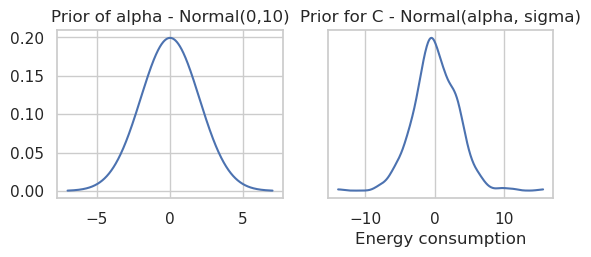

In [151]:
n_samples = 1000
alpha_mean = 0
alpha_std = 2

ax1 = plt.subplot(2, 2, (1,1))
x = np.linspace(-7,7,n_samples)
alpha_sample = stats.norm.pdf(x, alpha_mean, alpha_std)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title("Prior of alpha - Normal(0,10)")

ax2 = plt.subplot(2, 2, (2,2))
alpha_sample = stats.norm.rvs(loc=alpha_mean, scale=alpha_std, size=n_samples)
sigma_sample = stats.expon.rvs(1, size=n_samples)
prior_h = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)
az.plot_kde(prior_h, ax=ax2)
ax2.set_xlabel("Energy consumption")
ax2.set_yticks([]);
ax2.set_title("Prior for C - Normal(alpha, sigma)")
plt.show()

Recall that category 0 for application is `c-sharp-razor`. We are now ready to create the PYMC model:

$$

\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{HalfNormal}(1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$

In [124]:
with pm.Model() as m_h1b:
    C_data = pm.Data("C_data", df["energy_consumption"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)


    alpha = pm.HalfNormal("alpha", 1, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", alpha[A_data])
    C = pm.Normal("C", mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1b = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

In [125]:
np.random.seed(rng)

n_samples = 1000
ax1 = plt.subplot(2, 2, (1,1))
x = np.linspace(-1,5,n_samples)
alpha_sample = stats.halfnorm.pdf(x, 0,1)
sigma_sample = stats.expon.pdf(x, 1)
ax1.plot(x, alpha_sample)
ax1.set_title("Prior of alpha - HalfNormal(0,1)")

ax2 = plt.subplot(2, 2, (2,2))
alpha_sample = stats.halfnorm.rvs(loc=0, scale=1, size=n_samples)
sigma_sample = stats.expon.rvs(1, size=n_samples)
prior_h = stats.norm.rvs(loc=alpha_sample, scale=sigma_sample)
# prior_h = stats.truncnorm()
az.plot_kde(
    prior_h, 
    ax=ax2
)
ax2.set_xlabel("Energy consumption")
# ax2.set_xlim(0, 20)
ax2.set_yticks([])
ax2.set_title("Prior for C - Normal(alpha, sigma)")
plt.show()

Looks a lot more reasonable, $\alpha$ can no longer be negative which better fits our domain knowledge. Additionally, the prior of $C$ is situated to the right of 0 which is preferable for the same reason as $\alpha$.

Next, we will consider the sampling process starting with a trace plot:

In [126]:
az.plot_trace(trace_h1b, var_names=["alpha"])

Looking at the plot trace - the sampling process looks successful. Specfically, in the right hand side plot we see good mixing in (read: *zig zagging*) and good convergance (chains are sticking to the same high probability areas). 

In [127]:
az.summary(trace_h1b, var_names=["alpha"])

Looking at the summary of the simulation, firstly we see that the $\hat r$ values are all 1, again suggesting that the sampling process was successful (and similarly the effective sample size (ess_bulk) is also high). 

Interestingly, considering only the alpha parameters, we see that the mean $\alpha$ is highest for the category "*c-sharp-razor*", and the model is fairly confident (low standard deviation).

Let's take a look at the "diff" which in this model are the contrasts between the baseline, "*c-sharp-razor*", and the other applications.

In [128]:
az.plot_forest(trace_h1b, var_names=["diff"], combined=True)

Recall that $0$ (zero) is the application "*c-sharp-razor*". We see from the forest plot of contrasts above that they are all sitting well to the left of 0.0, meaning that the energy consumption of "*c-sharp-razor*" is higher than all the other language/frameworks. We are able to reject hypothesis 1.

------

Posterior predictive check - let's see how well the model can recreate the data.

First we sample the posterior using pymc

In [129]:
with m_h1b:
    pm.sample_posterior_predictive(trace_h1b, extend_inferencedata=True, random_seed=rng)

In [130]:
_, ax = plt.subplots()
az.plot_ppc(trace_h1b, num_pp_samples = 200, ax=ax)

Looking at the posterior predictive we see that although the peak of our model isn't nearly as pronounced as the "observed" the location and width of the peak match that of the observed data.

### Improving the model



Looking at the posterior predictive check we are still not happy with the model. It severely underestimates the peak and the outcome variable can still be negative.

Looks Normal distribution might not fit the data, we think it looks like a LogNormal distribution. It starts above 0, rapidly increasing peak.

$$

\begin{aligned}
    C &\sim \text{LogNormal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,1) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}

$$



In [131]:
with pm.Model() as m_h1_lognormal:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 1, shape=(df["A"].max() + 1,))
    
    consumption = pm.LogNormal("consumption", mu[df["A"].values], sigma, observed=df["energy_consumption"])

    diff = pm.Deterministic("diff", mu - mu[0])

    trace_h1_lognormal = pm.sample(random_seed = rng, idata_kwargs = { 'log_likelihood': True })
    pm.sample_posterior_predictive(trace_h1_lognormal, extend_inferencedata=True, random_seed=rng)

Let's consider the sampling process

In [132]:
az.plot_trace(trace_h1_lognormal, var_names=["mu"])

This also looks good - mixing and convergence

In [133]:
az.plot_ppc(trace_h1_lognormal, num_pp_samples=100, figsize=(10, 5), random_seed=42)

Look at the beauty. Compared to the normal distribution our new posterior predictive check creates the data much better!

Let's take a look at the contrasts.

In [134]:
az.plot_forest(trace_h1_lognormal, var_names=["diff"], combined=True)

In [135]:
az.summary(trace_h1_lognormal, var_names=["mu", "sigma"])

**TODO: Explain the results from the lognormal model.**

**TODO: Motivate why running time is interesting because of the results from lognormal**

In [136]:
with pm.Model() as m_h1_with_runningtime:
    alpha = pm.Normal("alpha", 0,1)
    sigma = pm.Exponential("sigma", 1)
    beta  = pm.Normal("beta", 0,1, shape=df["A"].unique().size)

    C_data = pm.Data("C_data", df["C"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)
    R_data = pm.Data("R_data", df["R_stand"].values, mutable=True)

    mu = pm.Deterministic("mu", alpha + beta[A_data] * R_data)
    C = pm.LogNormal("C", mu=mu, sigma=sigma, observed=C_data)

    diff = pm.Deterministic("diff", beta - beta[0])

    trace_h1_with_runningtime = pm.sample(random_seed=rng, idata_kwargs = { 'log_likelihood': True })

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [137]:
az.summary(trace_h1_with_runningtime, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.119,0.007,-1.132,-1.107,0.0,0.0,4339.0,3218.0,1.0
beta[0],0.445,0.008,0.431,0.460,0.0,0.0,4758.0,2928.0,1.0
beta[1],1.350,0.026,1.303,1.401,0.0,0.0,5269.0,3009.0,1.0
beta[2],1.075,0.029,1.021,1.131,0.0,0.0,5449.0,3336.0,1.0
beta[3],0.971,0.022,0.930,1.011,0.0,0.0,5543.0,3639.0,1.0
beta[4],0.696,0.027,0.647,0.747,0.0,0.0,5446.0,3397.0,1.0
beta[5],0.830,0.022,0.788,0.869,0.0,0.0,5081.0,3394.0,1.0
beta[6],0.928,0.031,0.865,0.986,0.0,0.0,4762.0,2968.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

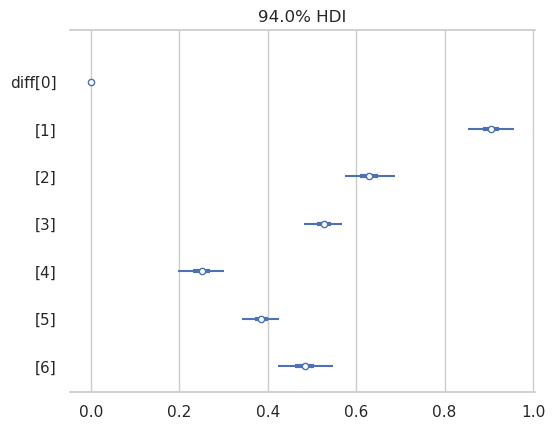

In [138]:
az.plot_forest(trace_h1_with_runningtime, var_names=["diff"], combined=True)

Interesting - per running time unit (seconds) C\# performs better than the other languages.

**TODO: Motivate why comparing is fun**

In [139]:
az.compare({'normal':trace_h1b, 'lognormal':trace_h1_lognormal, 'with runningtime': trace_h1_with_runningtime}, ic='waic')

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
with runningtime,0,2160.190704,51.530009,0.000000,0.987337,108.680929,0.000000,True,log
lognormal,1,372.824999,8.924437,1787.365705,0.000326,41.554404,92.998326,False,log
normal,2,-189.312667,10.915078,2349.503371,0.012338,60.314034,91.350829,True,log


**TODO: What do theese results tell us?**

We see that the model using a lognormal likelihood has a better predictive capability. 
- elpd_waic is higher (because we are not on deviance scale). 
- p_waic (effective parameters) is also lower 
- weight = bigger

## Conclusion on H1

- We don't know enough about the data gathering process for a decisive conclusion

#### Notes:

- C\# energy consumption may be high because of garbage collection or JIT may result in longer requests. More energy spent on GC and JIT.
-  

----

## If time permits?

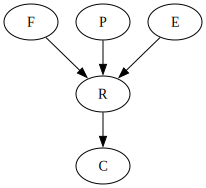

In [140]:
from causalgraphicalmodels import CausalGraphicalModel

potential1 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("P", "R"), ("F", "R"), ("R", "C"), ("E", "R")])
potential1.draw()


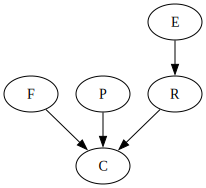

In [141]:
potential2 = CausalGraphicalModel(["P", "F", "R","C", "E"], [("R","C"), ("E","R"), ("F","C"), ("P", "C")])
potential2.draw()

In [142]:
df["L"] = pd.Categorical(df["language"]).codes
df["F"] = pd.Categorical(df["framework"]).codes
df.groupby('language').endpoint.nunique().reset_index().sort_values('endpoint', ascending=False)

,language,endpoint
0,c-sharp,14
1,go,14
2,javascript,14
3,python,14
4,ruby,14
5,rust,14


In [143]:
# with pm.Model() as m_h2_lognormal:
#     sigma = pm.Exponential("sigma", 1)
#     # shape defines a vector size (+1 because ids start from zero)
#     # we will have four different mu's for K
#     mu_L = pm.Normal("mu_L", 0, 1, shape=(df["L"].max() + 1,))
#     mu_F = pm.Normal("mu_F", 0, 1, shape=(df["F"].unique().size))
#     # it is crazy implicit how pymc matches rows in d["clade_id"] and d["K"]
#     consumption = pm.LogNormal("consumption", mu_L[df["L"].values] + mu_F[df["F"].values], sigma, observed=df["energy_consumption"])

#     trace_h2_lognormal = pm.sample(random_seed = rng, idata_kwargs = { 'log_likelihood': True })
#     pm.sample_posterior_predictive(trace_h2_lognormal, extend_inferencedata=True, random_seed=rng)

In [144]:
# az.plot_forest(trace_h2_lognormal, var_names=["mu_L", "mu_F"], combined=True)